In [1]:
from scipy.stats import bernoulli
from functions import read_input_data, cal_income
from constants import education_level, MU, RETIRE_AGE, START_AGE, unempl_rate, unemp_frac, END_AGE, ret_frac, AltDeg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
income_fp = './data/age_coefficients_and_var.xlsx'
mortal_fp = './data/Conditional Survival Prob Feb 16.xlsx'
age_coeff, std, surv_prob = read_input_data(income_fp, mortal_fp)
print(age_coeff)
print('\n')
print(std.loc[:, 'Labor Income Only'])

                              a         b1         b2        b3
No High School         41078.88 -2201.5820  78.223410 -0.788948
High School Graduates  28752.76  -917.5466  51.095140 -0.608928
College Graduates     -51819.03  3553.4590   0.933759 -0.549925


                  No High School  High School Graduates  College Graduates
sigma_permanent         0.157162               0.137113           0.143875
sigma_transitory        0.339190               0.233773           0.229565


## Income Process for College Students [excel output]

In [83]:
N_SIM = 100000
AltDeg = 4
income = cal_income(age_coeff)
sigma_perm = std.loc['sigma_permanent', 'Labor Income Only'][education_level[AltDeg]]
sigma_tran = std.loc['sigma_transitory', 'Labor Income Only'][education_level[AltDeg]]

In [84]:
# generate random walk and normal r.v.
rn_perm = np.random.normal(MU, sigma_perm, (N_SIM, RETIRE_AGE - START_AGE + 1))
rand_walk = np.cumsum(rn_perm, axis=1)
rn_tran = np.random.normal(MU, sigma_tran, (N_SIM, RETIRE_AGE - START_AGE + 1))
inc_with_inc_risk = np.multiply(np.exp(rand_walk) * np.exp(rn_tran), income)

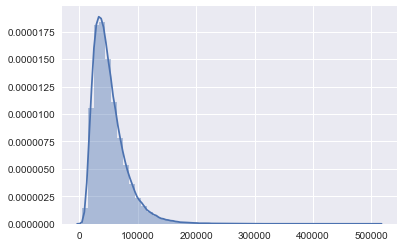

In [85]:
sns.distplot(inc_with_inc_risk[:, 10]);

In [86]:
# - retirement
ret_income_vec = ret_frac[AltDeg] * np.tile(inc_with_inc_risk[:, -1], (END_AGE - RETIRE_AGE, 1)).T
inc_with_inc_risk = np.append(inc_with_inc_risk, ret_income_vec, axis=1)

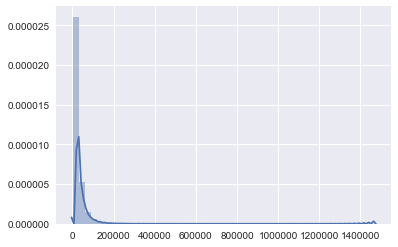

In [87]:
# inc_with_inc_risk.shape
sns.distplot(inc_with_inc_risk[:, 50]); # after age 65, inc has the same distribution 

In [88]:
ave_inc_each_age = inc_with_inc_risk.mean(axis=0)
ave_inc_each_age

array([ 21761.41205464,  24868.15277094,  27984.51218404,  31027.16361224,
        34095.66715752,  37111.11059336,  40188.11287907,  43112.85007065,
        46013.71857726,  48737.1815041 ,  51619.32924942,  54331.81433879,
        56934.52455454,  59491.9204247 ,  61883.7114376 ,  64250.65189152,
        66649.45143821,  68647.26462479,  70861.48936358,  72806.23941915,
        74387.7905705 ,  76149.50296511,  77580.35137415,  79018.97671164,
        80126.16659943,  80859.20587089,  81605.21669875,  82224.98536998,
        82392.80481183,  82538.06882648,  82366.29863784,  82093.49025208,
        81121.29145744,  80222.74712361,  78861.64895066,  77471.31631843,
        75592.2089591 ,  73360.83717074,  70873.16472891,  67852.91025566,
        64378.62812472,  60640.48135022,  56352.96561319,  51983.15967487,
        23475.59490917,  23475.59490917,  23475.59490917,  23475.59490917,
        23475.59490917,  23475.59490917,  23475.59490917,  23475.59490917,
        23475.59490917,  

In [89]:
std_each_age = inc_with_inc_risk.std(axis=0)
std_each_age

array([  6013.25573062,   7764.82352376,   9745.08699443,  11744.66317947,
        13897.39868453,  16259.97275066,  18761.69164274,  21238.2833571 ,
        23776.30333892,  26445.98431972,  29236.43127102,  32110.83924045,
        34878.57306544,  37780.13241817,  40785.21640584,  43409.47467815,
        46682.75780508,  49522.63369896,  52783.34910788,  55881.67189886,
        58616.33948909,  61654.11802502,  64142.55336251,  68024.06677239,
        69969.16595294,  72750.0799606 ,  75090.74539698,  77636.26972782,
        79107.98891783,  81283.22948641,  83250.18350388,  83989.06704974,
        84806.31983406,  85890.57872523,  86296.09547715,  86525.59344134,
        86504.67703563,  84639.88470701,  83581.86428894,  81917.38631864,
        79041.20243802,  74686.84355503,  71050.29562007,  67093.94116299,
        30299.62382921,  30299.62382921,  30299.62382921,  30299.62382921,
        30299.62382921,  30299.62382921,  30299.62382921,  30299.62382921,
        30299.62382921,  

In [90]:
temp = (ave_inc_each_age + 3 * std_each_age) * 1.02
temp.sum()

14345624.678944083

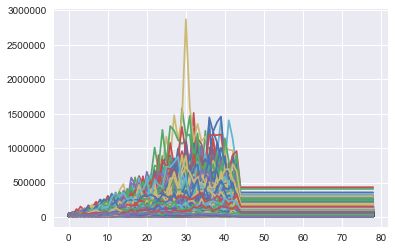

In [119]:
age = np.arange(79)
plt.plot(age, inc_with_inc_risk[:10000, :].T)
plt.show()


In [120]:
# generate bernoulli random variable 
p = 1- unempl_rate[AltDeg]
r = bernoulli.rvs(p, size=(44, N_SIM)).astype(float)
r[r==0] = unemp_frac[AltDeg]

In [121]:
r.shape # 44 bernoulli r.v., each with 10000 randome variates 

(44, 100000)

In [123]:
ones = np.ones((END_AGE - RETIRE_AGE, N_SIM))
bern = np.append(r, ones, axis=0)

# output
inc_proc = np.multiply(inc_with_inc_risk, bern.T)
# df = pd.DataFrame(inc_proc)
# df.to_excel('income_process.xlsx', index=False)

In [124]:
# sanity check: at each age, the unemployment rate is around 0.0738
(inc_proc[:, 2] < inc_with_inc_risk[:, 2]).sum() / N_SIM

0.073539999999999994

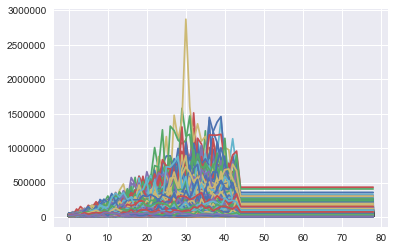

In [125]:
age = np.arange(79)
plt.plot(age, inc_proc[:10000, :].T)
plt.show()